# Исследование объявлений о продаже квартир

В моем распоряжении данные сервиса Яндекс Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктах за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости.

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта и других объектов — эти данные автоматически получены из геосервисов. Количество парков и водоёмов также заполняется без участия пользователя.

### Содержание
* [Изучение данных](#first-bullet)
* [Предобработка данных](#second-bullet)
* [Добавление столбцов](#third-bullet)
* [Исследовательский анализ данных](#fourth-bullet)
* [Общий вывод](#fifth-bullet)

<a class="anchor" id="first-bullet"></a>
### Изучение данных

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

In [5]:
data = pd.read_csv('real_estate_data.csv', sep='\t')
data.head()

total_images  last_price  total_area first_day_exposition  rooms  \
0            20  13000000.0       108.0  2019-03-07T00:00:00      3   
1             7   3350000.0        40.4  2018-12-04T00:00:00      1   
2            10   5196000.0        56.0  2015-08-20T00:00:00      2   
3             0  64900000.0       159.0  2015-07-24T00:00:00      3   
4             2  10000000.0       100.0  2018-06-19T00:00:00      2   

   ceiling_height  floors_total  living_area  floor is_apartment  ...  \
0            2.70          16.0         51.0      8          NaN  ...   
1             NaN          11.0         18.6      1          NaN  ...   
2             NaN           5.0         34.3      4          NaN  ...   
3             NaN          14.0          NaN      9          NaN  ...   
4            3.03          14.0         32.0     13          NaN  ...   

   kitchen_area  balcony    locality_name  airports_nearest  \
0          25.0      NaN  Санкт-Петербург           18863.0   
1          11.0      2.0   посёлок Шушары           12817.0   
2           8.3      0.0  Санкт-Петербург           21741.0   
3           NaN      0.0  Санкт-Петербург           28098.0   
4          41.0      NaN  Санкт-Петербург           31856.0   

  cityCenters_nearest  parks_around3000  parks_nearest  ponds_around3000  \
0             16028.0               1.0          482.0               2.0   
1             18603.0               0.0            NaN               0.0   
2             13933.0               1.0           90.0               2.0   
3              6800.0               2.0           84.0               3.0   
4              8098.0               2.0          112.0               1.0   

   ponds_nearest  days_exposition  
0          755.0              NaN  
1            NaN             81.0  
2          574.0            558.0  
3          234.0            424.0  
4           48.0            121.0  

[5 rows x 22 columns]

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

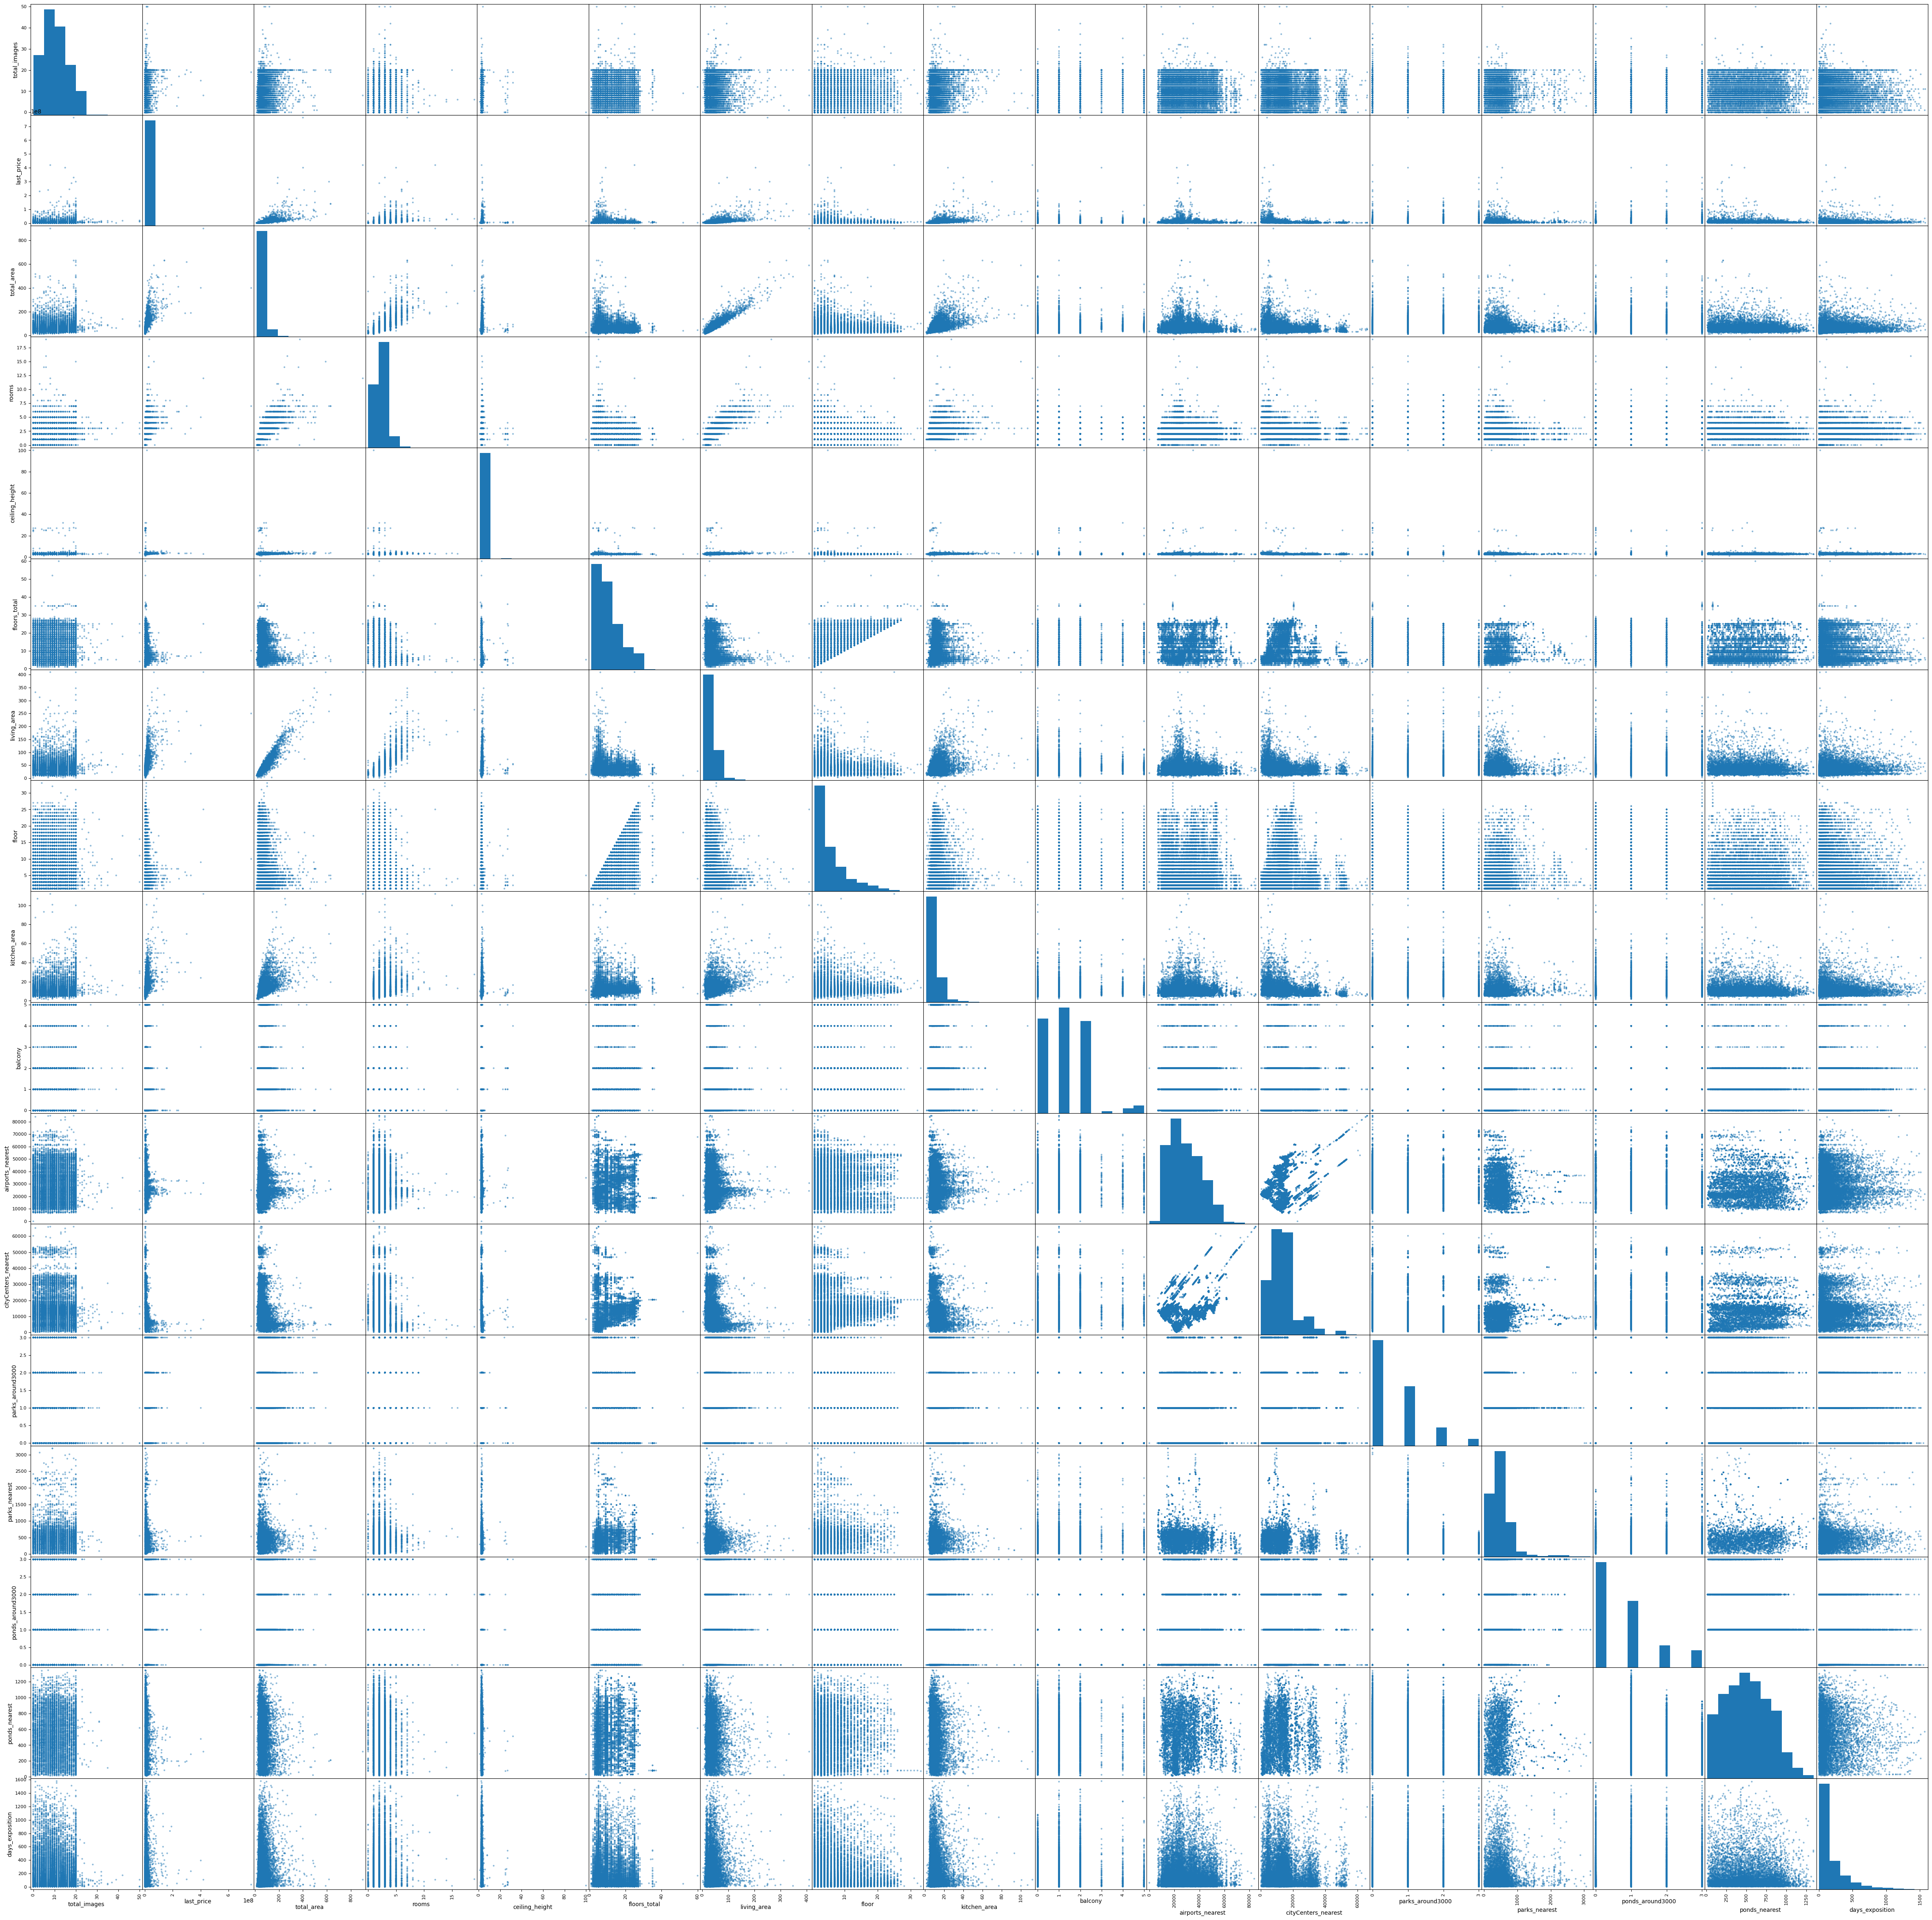

In [7]:
pd.plotting.scatter_matrix(data.select_dtypes(include='number'), figsize=(60, 60))
plt.show()

В данных 23.7 тысячи строк и 22 колонки, занимающих меньше 4 МБ, что позволяет работать с данными быстро, без большого времени на обработку данных, также стразу можно сказать, что некоторые поля например `balcony` имеют много пропусков и с этим придется бороться.

<a class="anchor" id="second-bullet"></a>
### Предобработка данных

In [10]:
data.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

В данных довольно много пропусков и вот как я считаю лучше поступить с каждым из них:
- `ceiling_height` заполнить медианой по району `localty_name`
- `floors_total` заполнить самым частым по району
- `is_apartment` так как пропуски почти во всей выборке, я считаю что можно заполнить как False
- `kitchen_area` заполнить медианой
- `balcony` заполнить нулями, так как вероятно балконов нет
- `localty_name` заменить NaN на `'unknown'`
- `airports_nearest` заполнить медианой по району
- `cityCenters_nearest` заполнить медианой по району
- `parks_around3000` заполнить медианой по району
- `parks_nearest` заполнить 3000
- `ponds_around3000` заполнить медианой по району
- `ponds_nearest` заполнить 3000
- `days_exposition` заполнить медианой


[notice] A new release of pip is available: 25.0 -> 25.2
[notice] To update, run: pip install --upgrade pip


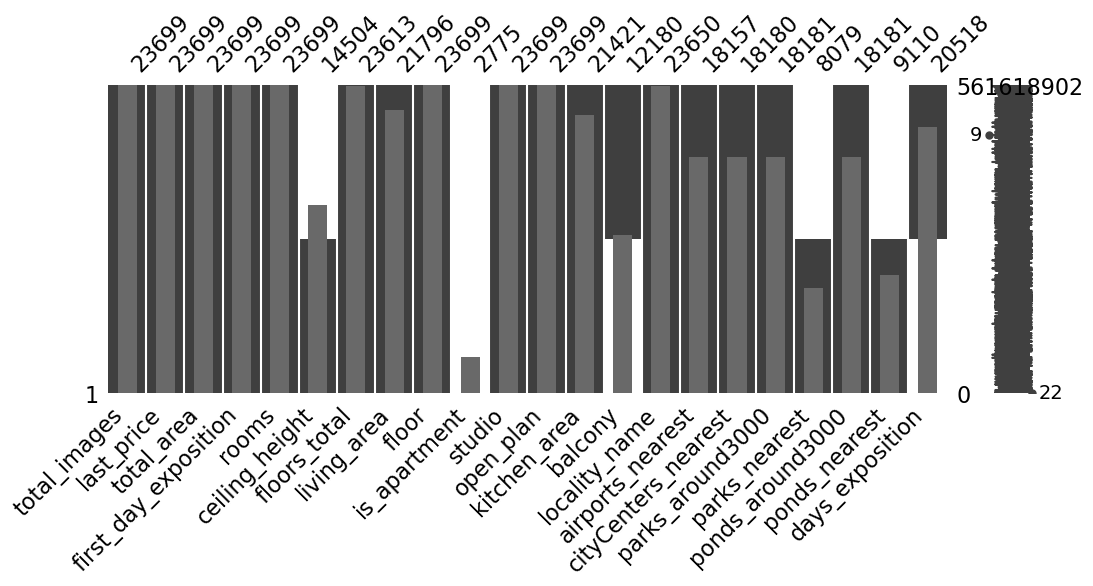

In [12]:
!pip -q install missingno
import missingno as msno
msno.matrix(data, figsize=(12, 6))
msno.bar(data, figsize=(12, 4))
plt.show()

Пропуски могут быть вызваны ошибкой при заполнении данных, ошибки как системной для автоматически сгенерированных данных, так и человеской при создании объявления. 

In [14]:
data['floors_total'] = data['floors_total'].fillna(data['floors_total'].mode()[0])
data['is_apartment'] = data['is_apartment'].fillna(False)
data['kitchen_area'] = data['kitchen_area'].fillna(data['kitchen_area'].median())
data['balcony'] = data['balcony'].fillna(0)
data['locality_name'] = data['locality_name'].fillna('unknown')
data['ceiling_height'] = data['ceiling_height'].fillna(data.groupby('locality_name')['ceiling_height'].transform('median'))
data['living_area'] = data['living_area'].fillna(data.groupby('rooms')['living_area'].transform('median'))
data['ceiling_height'] = data['ceiling_height'].fillna(data['ceiling_height'].median())
data['airports_nearest'] = data['airports_nearest'].fillna(data.groupby('locality_name')['airports_nearest'].transform('median'))
data['airports_nearest'] = data['airports_nearest'].fillna(data['airports_nearest'].median())
data['cityCenters_nearest'] = data['cityCenters_nearest'].fillna(data.groupby('locality_name')['cityCenters_nearest'].transform('median'))
data['cityCenters_nearest'] = data['cityCenters_nearest'].fillna(data['cityCenters_nearest'].median())
data['parks_around3000'] = data['parks_around3000'].fillna(data.groupby('locality_name')['parks_around3000'].transform('median'))
data['parks_around3000'] = data['parks_around3000'].fillna(data['parks_around3000'].median())
data['parks_nearest'] = data['parks_nearest'].fillna(3000)
data['ponds_around3000'] = data['ponds_around3000'].fillna(data.groupby('locality_name')['ponds_around3000'].transform('median'))
data['ponds_around3000'] = data['ponds_around3000'].fillna(data['ponds_around3000'].median())
data['ponds_nearest'] = data['ponds_nearest'].fillna(3000)
data['days_exposition'] = data['days_exposition'].fillna(data['days_exposition'].median())
data.isna().sum()

/var/folders/72/fvkccqv51k3g5smc3bsp9x500000gn/T/ipykernel_84045/4016105399.py:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data['is_apartment'] = data['is_apartment'].fillna(False)


total_images            0
last_price              0
total_area              0
first_day_exposition    0
rooms                   0
ceiling_height          0
floors_total            0
living_area             0
floor                   0
is_apartment            0
studio                  0
open_plan               0
kitchen_area            0
balcony                 0
locality_name           0
airports_nearest        0
cityCenters_nearest     0
parks_around3000        0
parks_nearest           0
ponds_around3000        0
ponds_nearest           0
days_exposition         0
dtype: int64

Изменим типы данных в некоторых столбцах:
- В столбце `first_day_exposition` заменим на datetime, чтобы было удобнее работать как с датой
- В столбце `balcony` на int потому что число балконов не может быть не целым
- В столбце `days_exposition` на int потому что только целое число дней

In [16]:
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'])
data['balcony'] = data['balcony'].astype('int32')
data['days_exposition'] = data['days_exposition'].astype('int32')

В данных много неявных дубликатов из-за букв е и ё, а также где-то написаны полные названия, например поселок городского типа n, а где то краткие, просто n. Приведем их к одному виду

In [18]:
print(len(data['locality_name'].unique()))
import re
def normalize(name):
    n = name.lower().replace('ё', 'е')
    n = re.sub(r'\b(городской|поселок|посёлок|деревня|село|садовое|товарищество|тип[аи]|городского)\b',
               '', n)
    return ' '.join(n.split())
data['locality_name'] = data['locality_name'].apply(normalize)
len(data['locality_name'].unique())

365


310

<a class="anchor" id="third-bullet"></a>
### Добавьте в таблицу новые столбцы

In [20]:
data['price_per_m'] = data['last_price'] / data['total_area']
data['day_of_publication'] = data['first_day_exposition'].dt.weekday
data['month_of_pulication'] = data['first_day_exposition'].dt.month
data['year'] = data['first_day_exposition'].dt.year
def floor_type(row):
    if row['floor'] == 1:
        return 'первый'
    elif row['floor'] == row['floors_total']:
        return 'последний'
    else:
        return 'другой'
data['floor_type'] = data.apply(floor_type, axis=1)
data['cityCenters_nearest'] = (data['cityCenters_nearest']/1000).round()

<a class="anchor" id="fourth-bullet"></a>
### Проведите исследовательский анализ данных

count    23699.000000
mean        60.348651
std         35.654083
min         12.000000
25%         40.000000
50%         52.000000
75%         69.900000
max        900.000000
Name: total_area, dtype: float64

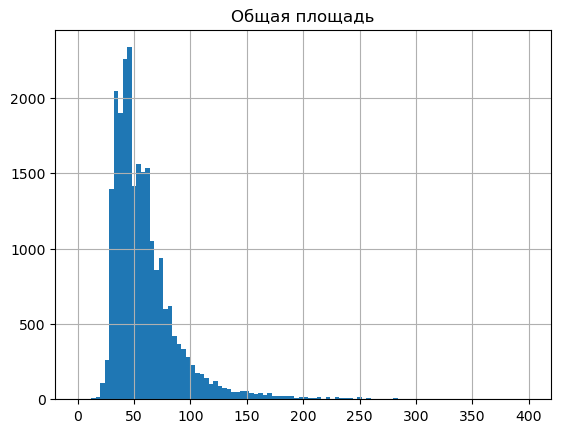

In [22]:
total_area_hist = data['total_area'].hist(bins=100, range=(0, 400))
total_area_hist.set_title('Общая площадь')
data['total_area'].describe()

В целом данные показывают, что больше всего квартир с площадью около 45 метров, но есть и уникальные примеры, как квартира с площадью 900, но в целом квартир больше 250 метров достаточно мало

In [24]:
bad = data.loc[data['living_area'] > data['total_area'], 
               ['living_area', 'total_area', 'rooms', 'balcony', 'first_day_exposition']]
bad.sort_values('living_area', ascending=False)

living_area  total_area  rooms  balcony first_day_exposition
14603      145.000       100.6      7        0           2018-07-31
14649      123.900       106.0      6        0           2018-07-08
12186       91.785        71.4      5        0           2017-09-21
12827       91.785        67.0      5        0           2018-02-16
13006       63.600        62.0      4        0           2018-02-01
20102       63.600        42.0      4        0           2018-02-15
18655       63.600        59.0      4        0           2018-01-12
17472       63.600        50.0      4        0           2018-02-20
17083       63.600        50.0      4        0           2018-02-22
16672       63.600        61.8      4        0           2018-01-05
13034       63.600        42.0      4        0           2018-03-25
1595        63.600        62.4      4        1           2019-04-23
11977       63.600        62.0      4        0           2018-07-08
9964        63.600        49.5      4        0           2018-10-02
3374        45.000        41.5      3        0           2018-02-14
14845       45.000        42.0      3        0           2017-12-25
22306       45.000        41.0      3        0           2017-12-18
11814       45.000        42.0      3        0           2018-02-12
8976        45.000        41.2      3        0           2017-03-17
18450       45.000        42.0      3        0           2016-06-22
18552       45.000        42.0      3        0           2018-04-02
9795        45.000        42.0      3        0           2017-11-20
12129       30.500        30.0      2        0           2018-08-05
19558       17.600        13.2      1        0           2018-12-17
17961       17.600        13.0      1        0           2017-12-03
19546       17.600        13.0      1        0           2019-03-11
12040       17.600        15.0      1        0           2018-06-27
16949       17.600        15.0      1        0           2018-08-21
22356       17.600        17.2      1        0           2019-01-13

По данным видно, что есть ошибки, в некоторых квартирах жилая площадь больше общей, для тех их них у кого разница между общей площадью и жилой меньше метра, я привел их к общей площади, а остальные значения отбросил. Так в целом по данным можно заметить, что есть стандартные планировки и в них у данных случался пик

Text(0.5, 1.0, 'Жилая площадь')

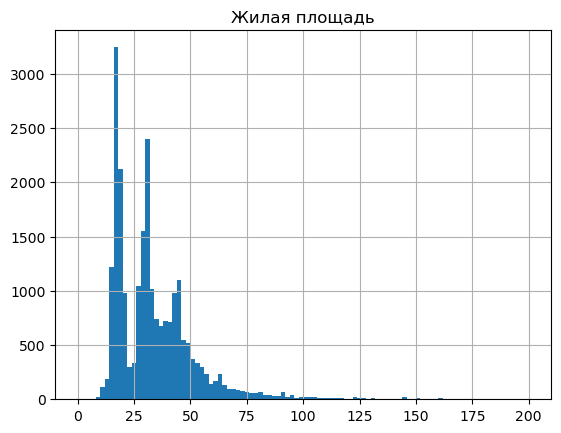

In [26]:
data.loc[(data['living_area'] > data['total_area']) & 
         ((data['living_area'] - data['total_area']) < 1),
        'living_area'] = data.loc[(data['living_area'] > data['total_area']) &
    ((data['living_area'] - data['total_area']) < 1), 'total_area']
living_area_hist = data['living_area'].hist(bins=100, range=(0, 200))
living_area_hist.set_title('Жилая площадь')


count    23699.000000
mean        10.428526
std          5.631126
min          1.300000
25%          7.400000
50%          9.100000
75%         11.440000
max        112.000000
Name: kitchen_area, dtype: float64

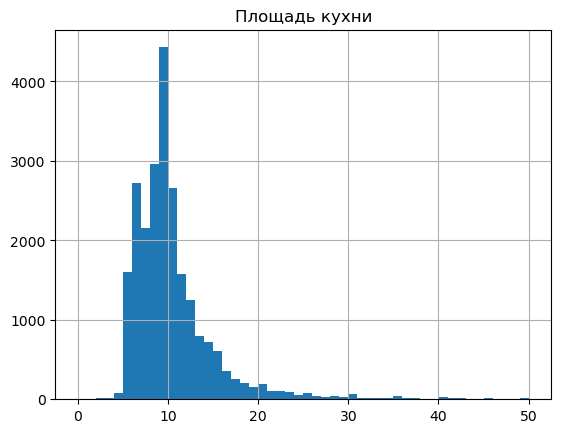

In [27]:
kitchen_area_hist = data['kitchen_area'].hist(bins=50, range=(0, 50))
kitchen_area_hist.set_title('Площадь кухни')
data['kitchen_area'].describe()

Площадь кухни достаточно сильно меняется, но среднее и медиана не сильно отличаются, в среднем площадь кухни около 10 метров

count    2.347400e+04
mean     6.596887e+06
std      1.092430e+07
min      1.000000e+06
25%      3.470000e+06
50%      4.650130e+06
75%      6.800000e+06
max      7.630000e+08
Name: last_price, dtype: float64

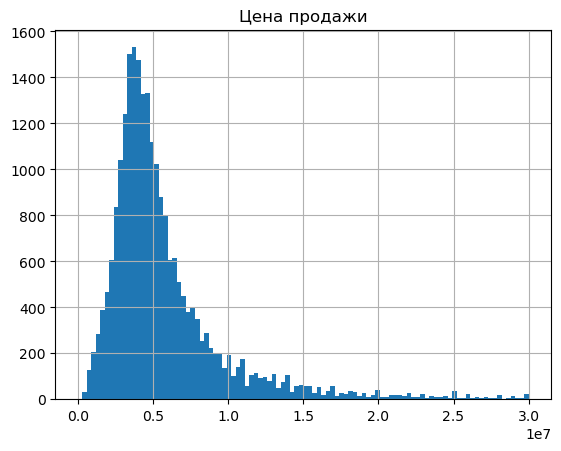

In [29]:
last_price_hist = data['last_price'].hist(bins=100, range=(0, 30000000))
last_price_hist.set_title('Цена продажи')
data = data[data['last_price'] >= 1000000]
data['last_price'].describe()

Я отсек часть данных с ценой ниже миллиона так как сильно сомневаюсь, что есть квартиры в Ленинградской области и Санкт-Петергбурге стоимостью меньше этой суммы

count    23474.000000
mean         2.074380
std          1.080655
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         19.000000
Name: rooms, dtype: float64

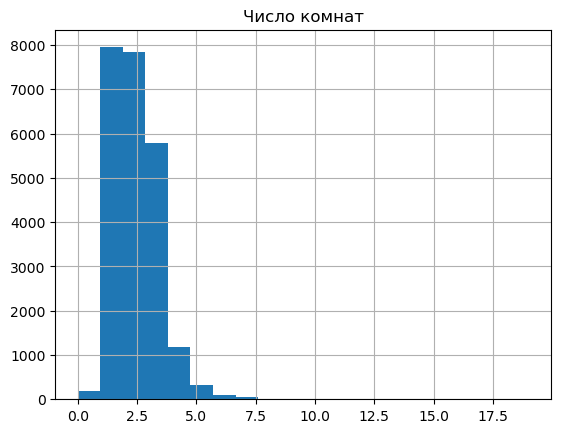

In [31]:
rooms_hist = data['rooms'].hist(bins=20)
rooms_hist.set_title('Число комнат')
data['rooms'].describe()

В среднем квартиры 1-2 комантные, 3 комнатных также немало, дальше количество квартир резко убывает

count    23474.000000
mean         2.705390
std          0.240913
min          1.000000
25%          2.550000
50%          2.700000
75%          2.700000
max         10.000000
Name: ceiling_height, dtype: float64

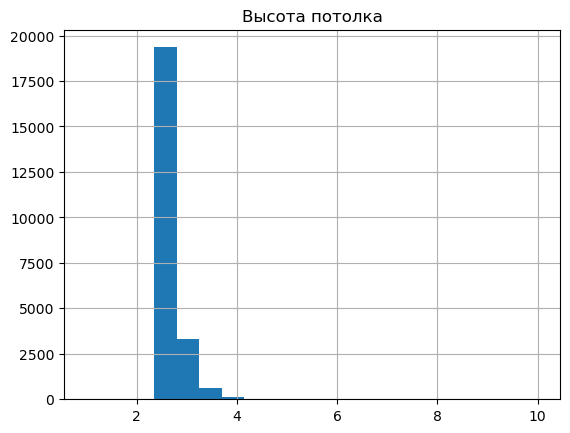

In [33]:
data.loc[data['ceiling_height'] > 10, 'ceiling_height'] = data.loc[data['ceiling_height'] > 10, 'ceiling_height'] / 10
ceiling_height_hist = data['ceiling_height'].hist(bins=20)
ceiling_height_hist.set_title('Высота потолка')
data['ceiling_height'].describe()

Для квартир с высотой потолка больше 10 метров, я разделил значения на 10, так как скорее всего возникла ошибка при сборе данных, средняя и медиана высот получились равными

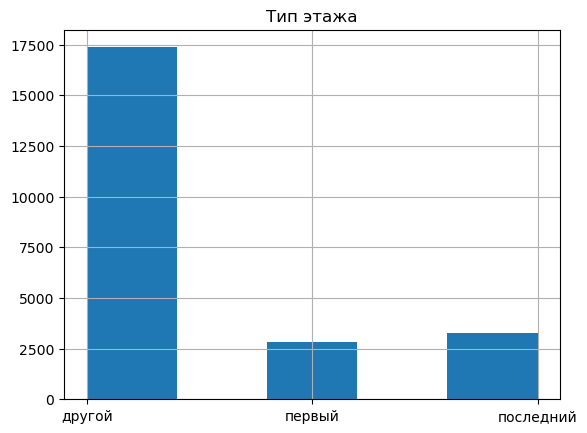

In [35]:
floor_type_hist = data['floor_type'].hist(bins=5).set_title('Тип этажа')

Легко заметить, что квартир расположенных на первых и последних этажах достаточно мало

count    23474.000000
mean        10.715984
std          6.590852
min          1.000000
25%          5.000000
50%          9.000000
75%         16.000000
max         60.000000
Name: floors_total, dtype: float64

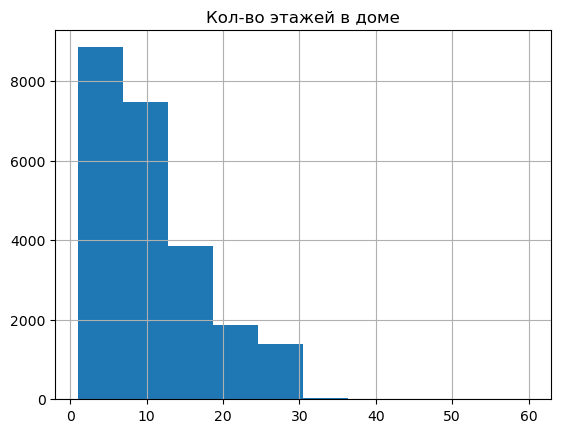

In [37]:
floors_total_hist = data['floors_total'].hist().set_title('Кол-во этажей в доме')
data['floors_total'].describe()

В среднем дома 9-10 этажные, но есть и дома выше 30 этажей

count    23474.000000
mean        13.953693
std          7.641637
min          0.000000
25%         11.000000
50%         13.000000
75%         15.000000
max         66.000000
Name: cityCenters_nearest, dtype: float64

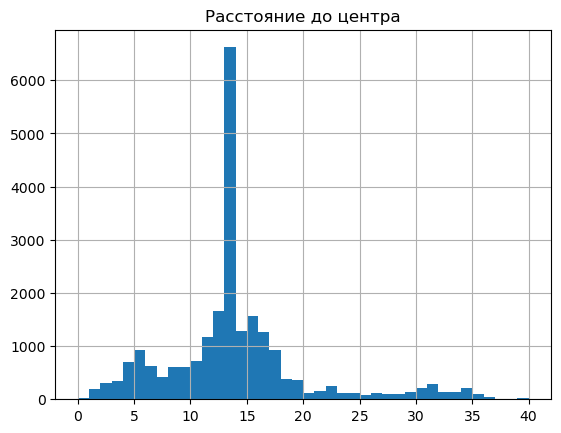

In [39]:
data['cityCenters_nearest'].hist(bins=40, range=(0, 40)).set_title('Расстояние до центра')
data['cityCenters_nearest'].describe()

График показывает, что большая часть квартир расположена на расстоянии 13 километров от центра

count    23474.000000
mean      2136.508690
std       1208.911919
min          1.000000
25%        595.000000
50%       3000.000000
75%       3000.000000
max       3190.000000
Name: parks_nearest, dtype: float64

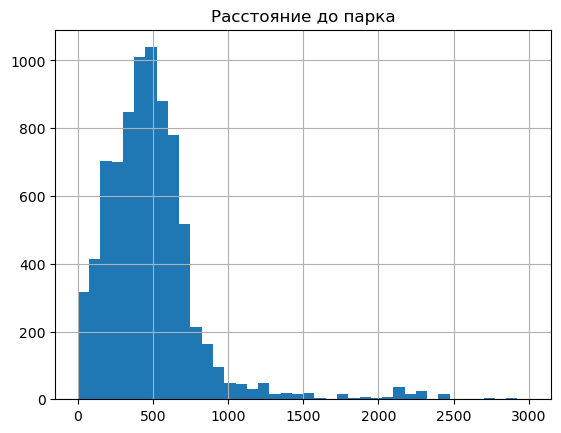

In [41]:
data['parks_nearest'].hist(bins=40, range=(0, 2999)).set_title('Расстояние до парка')
data['parks_nearest'].describe()

Я не учитывая данные больше 3000, так как при обработке данных, я заменил пропуски на 3000, но в остальном, в среднем ближайший парк расположен в 500 метрах от недвижимости

count    23474.000000
mean       169.606075
std        206.919319
min          1.000000
25%         45.000000
50%         95.000000
75%        199.000000
max       1580.000000
Name: days_exposition, dtype: float64

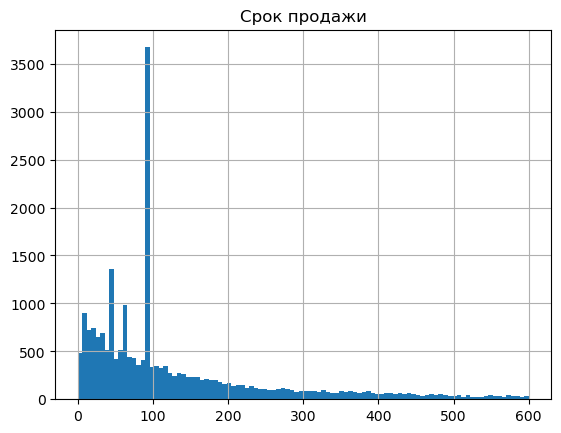

In [43]:
days_exposition_hist = data['days_exposition'].hist(bins=100, range=(0, 600)).set_title('Срок продажи')
data['days_exposition'].describe()

Есть высокие точки на графике, которые показывают скорее всего период автообновления объявлений на сайте по продажи недвижимости(45, 60, 90 дней), по медиане продажа обычно происходит в первые 100 дней, быстрой продажей можно считать те, что заняли меньше 45 дней, медленной - больше 200. Объявление которое висело 1580 дней вероятно ошибка(забыли снять объявление, несоразмерно высокая цена и тп). 

In [45]:
import matplotlib.pyplot as plt

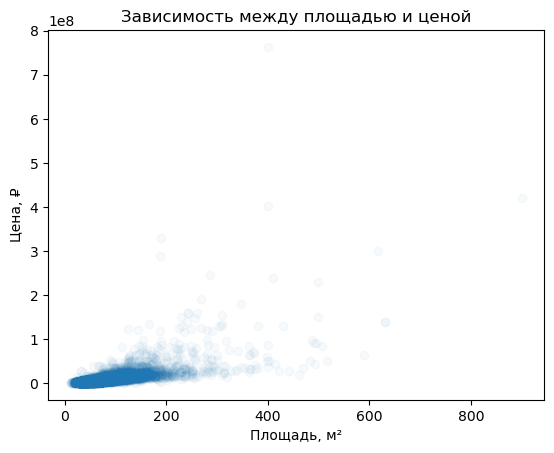

0.6531025987564582

In [46]:
plt.scatter(data['total_area'], data['last_price'], alpha=0.03)
plt.xlabel('Площадь, м²')
plt.ylabel('Цена, ₽')
plt.title('Зависимость между площадью и ценой')
plt.show()
data['total_area'].corr(data['last_price'])

Зависимость между площадью и ценой есть, корреляция в 65% это доказывает

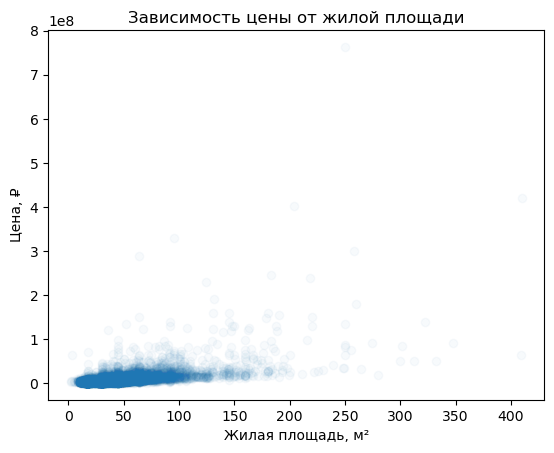

0.5556283670758724

In [48]:
plt.scatter(data['living_area'], data['last_price'], alpha=0.03)
plt.xlabel('Жилая площадь, м²')
plt.ylabel('Цена, ₽')
plt.title('Зависимость цены от жилой площади')
plt.show()
data['living_area'].corr(data['last_price'])

Зависимость между жилой площадью и ценой есть, не такая ярко выраженая как с общей площадью, но есть

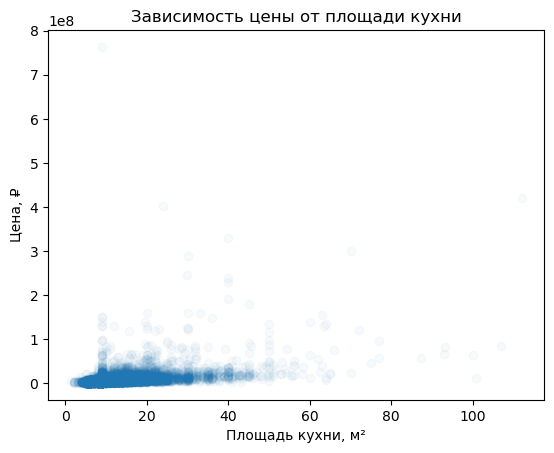

0.4393861019687932

In [50]:
plt.scatter(data['kitchen_area'], data['last_price'], alpha=0.03)
plt.xlabel('Площадь кухни, м²')
plt.ylabel('Цена, ₽')
plt.title('Зависимость цены от площади кухни')
plt.show()
data['kitchen_area'].corr(data['last_price'])

Зависимость между ценой и площадью кухни уже не такая явная

Text(0.5, 1.0, 'Цена в зависимости от типов этажей')

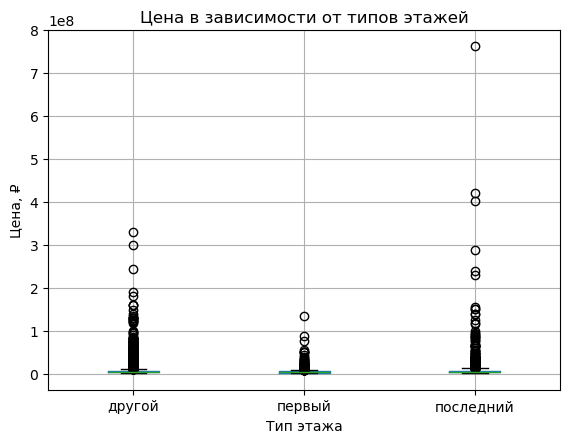

In [52]:
data.boxplot(column='last_price', by='floor_type')
plt.suptitle('')
plt.xlabel('Тип этажа')
plt.ylabel('Цена, ₽')
plt.title('Цена в зависимости от типов этажей')

Можно отметить, что цена для последних этажей обычно выше, чем для других, а для первых ниже

Text(0, 0.5, 'Цена, ₽')

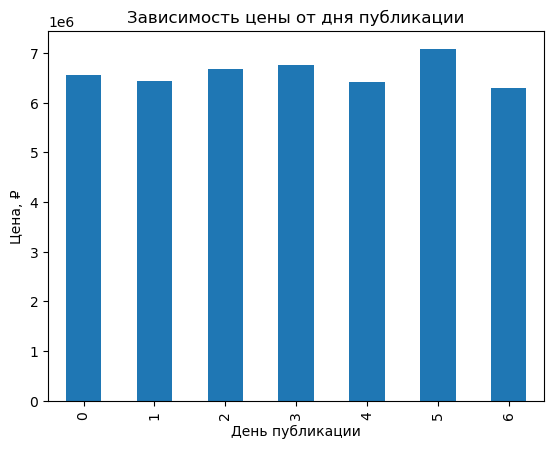

In [54]:
dop = data.groupby('day_of_publication')['last_price'].mean()
dop.plot(kind='bar')
plt.title('Зависимость цены от дня публикации')
plt.xlabel('День публикации')
plt.ylabel('Цена, ₽')

Можно заметить, что для объявлений сделанных в субботу обычн средняя цена немного выше

Text(0, 0.5, 'Цена, ₽')

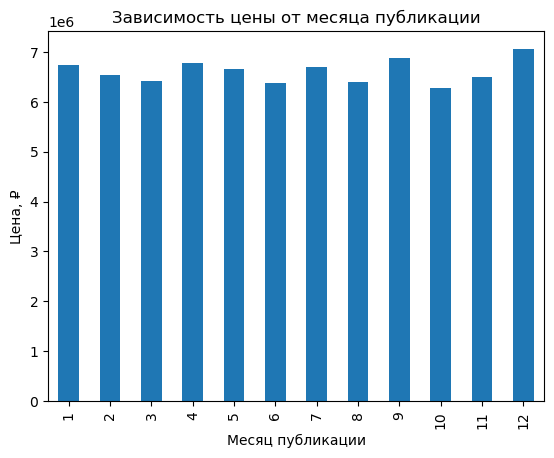

In [56]:
dom = data.groupby('month_of_pulication')['last_price'].mean()
dom.plot(kind='bar')
plt.title('Зависимость цены от месяца публикации')
plt.xlabel('Месяц публикации')
plt.ylabel('Цена, ₽')

В целом зависимости нет, но наблюдается небольшой тренд на повышение средней стоимости к зиме

Text(0, 0.5, 'Цена, ₽')

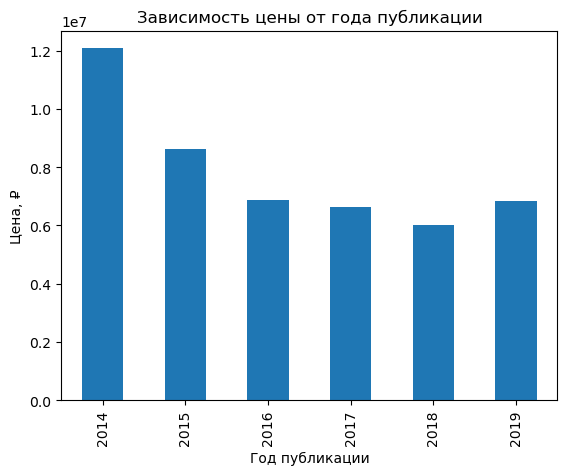

In [58]:
dom = data.groupby('year')['last_price'].mean()
dom.plot(kind='bar')
plt.title('Зависимость цены от года публикации')
plt.xlabel('Год публикации')
plt.ylabel('Цена, ₽')

Очевиден тренд снижения средней цены с 2014 по 2018, но к 2019 цена опять начала подниматься

In [60]:
top10_names = data['locality_name'].value_counts().head(10).index
top10 = data[data['locality_name'].isin(top10_names)].pivot_table(index='locality_name', values=['last_price', 'price_per_m'], aggfunc={'last_price':'count', 'price_per_m':'mean'}).sort_values(by='price_per_m', ascending=False)
top10.index.name = 'Город'
top10.columns = ['Количество продаж', 'Цена за квадратный метр']
top10

Количество продаж  Цена за квадратный метр
Город                                                      
санкт-петербург              15720            114856.307596
пушкин                         369            103125.819291
кудрово                        472             95324.930544
парголово                      327             90175.913458
мурино                         590             86087.512050
шушары                         440             78677.364217
колпино                        338             75424.579098
гатчина                        306             68935.194838
всеволожск                     397             68719.287383
выборг                         233             58685.669032

Легко заметить, что в Санкт-Петербурге самое большое число продаж

In [62]:
agg = data.groupby('locality_name').agg(listings=('last_price',   'count'),avg_price_per_m=('price_per_m', 'mean'))
agg_desc = agg.sort_values('avg_price_per_m', ascending=False)
top3 = agg_desc.head(3)
top3.index.name = 'Город'
top3.columns = ['Количество', 'Цена за метр']
bottom3 = agg_desc.tail(3)
bottom3.index.name = 'Город'
bottom3.columns = ['Количество', 'Цена за метр']
top3

Количество   Цена за метр
Город                                     
зеленогорск              24  115122.799198
санкт-петербург       15720  114856.307596
бор                       1  105539.261570

Самая высокая цена за квадратный метр оказалась в Зеленогорске, это курортный район, так что в этом есть логика. Насчет Бора, одна продажа не очень показательна

In [64]:
bottom3

Количество  Цена за метр
Город                                 
бокситогорск           2  19600.140713
никольский             3  19577.327649
житково                1  15648.286140

In [65]:
spb = data[data['locality_name'] == 'санкт-петербург'].copy()
mean_price_spb = spb.groupby('cityCenters_nearest')['last_price'].mean()
mean_df = mean_price_spb.to_frame('mean_price').reset_index()
mean_df.columns = ['Расстояние до центра', 'Средняя цена']
mean_df['Средняя цена'] = mean_df['Средняя цена'].astype(int)
mean_df

Расстояние до центра  Средняя цена
0                    0.0      31449115
1                    1.0      21206720
2                    2.0      17788319
3                    3.0      11126581
4                    4.0      13304279
5                    5.0      14499121
6                    6.0      15338418
7                    7.0      14775152
8                    8.0       9957716
9                    9.0       6962378
10                  10.0       6504119
11                  11.0       6250814
12                  12.0       6189738
13                  13.0       6083140
14                  14.0       5629101
15                  15.0       5884751
16                  16.0       5373130
17                  17.0       5292394
18                  18.0       5091331
19                  19.0       5037674
20                  20.0       5951464
21                  21.0       5493469
22                  22.0       5415524
23                  23.0       4985376
24                  24.0       3854429
25                  25.0       4052839
26                  26.0       3973012
27                  27.0       8300000
28                  28.0       5026428
29                  29.0       4236666

Text(19.0, 29545965.14730769, 'Пригород')

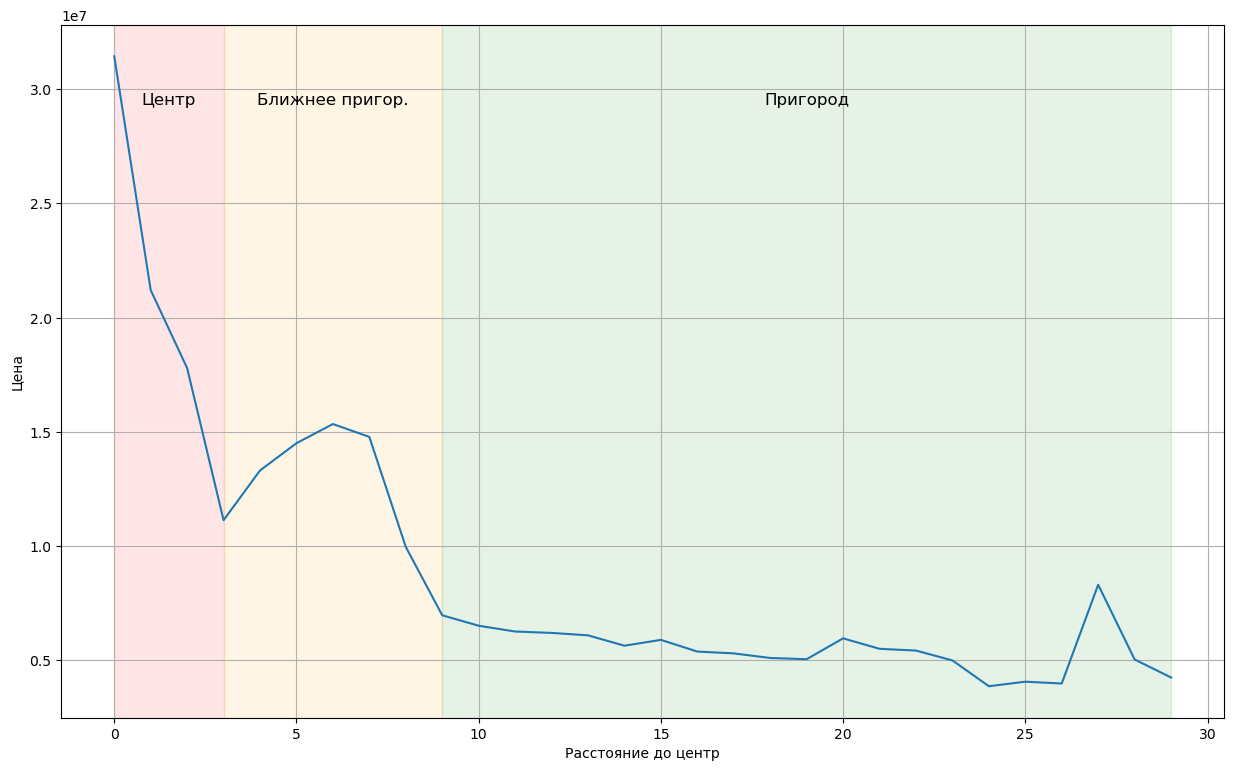

In [66]:
mean_price_spb.plot(grid=True, xlabel='Расстояние до центр', ylabel='Цена', figsize=(15, 9)).axvspan(0, 3, color='red', alpha=0.1)
plt.axvspan(3, 9, color='orange', alpha=0.1)
plt.axvspan(9, mean_price_spb.index.max(), color='green', alpha=0.1)
ylim = plt.ylim()
plt.text(3/2,   ylim[1]*0.9, 'Центр', ha='center', va='center', fontsize=12)
plt.text((3+9)/2, ylim[1]*0.9, 'Ближнее пригор.', ha='center', va='center', fontsize=12)
plt.text((9 + mean_price_spb.index.max())/2,   ylim[1]*0.9, 'Пригород', ha='center', va='center', fontsize=12)

Очень сильное снижение цены в первые 3 километра от центра и плавное убывание к пригороду

<a class="anchor" id="fifth-bullet"></a>
### Напишите общий вывод

В Ленинградской области можно отметить, что на цену недвижимости очень влияют следующие параметры:
- Общая площадь

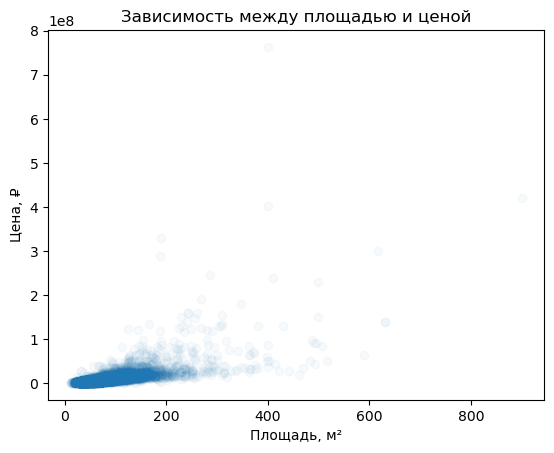

0.6531025987564582

In [70]:
plt.scatter(data['total_area'], data['last_price'], alpha=0.03)
plt.xlabel('Площадь, м²')
plt.ylabel('Цена, ₽')
plt.title('Зависимость между площадью и ценой')
plt.show()
data['total_area'].corr(data['last_price'])

- Жилая площадь

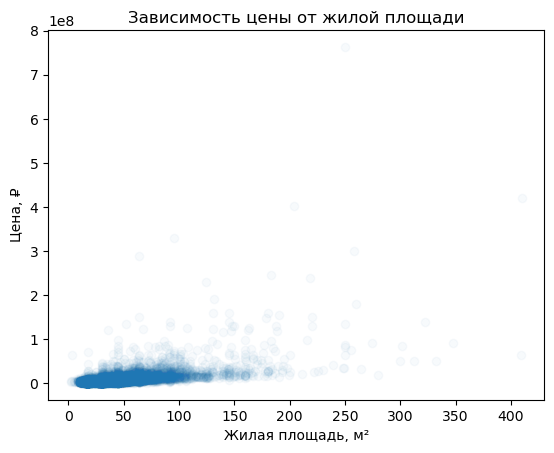

0.5556283670758724

In [72]:
plt.scatter(data['living_area'], data['last_price'], alpha=0.03)
plt.xlabel('Жилая площадь, м²')
plt.ylabel('Цена, ₽')
plt.title('Зависимость цены от жилой площади')
plt.show()
data['living_area'].corr(data['last_price'])

- Последний ли это этаж

Text(0.5, 1.0, 'Цена в зависимости от типов этажей')

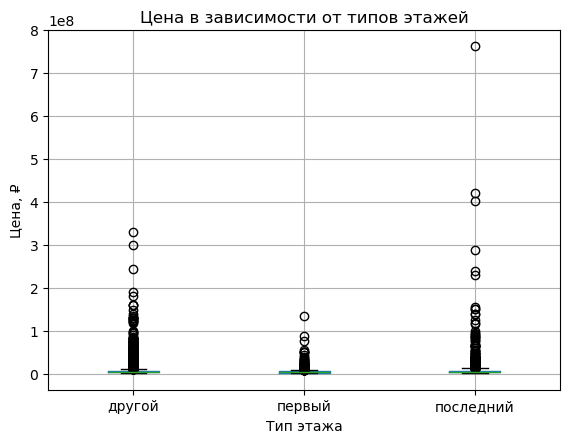

In [74]:
data.boxplot(column='last_price', by='floor_type')
plt.suptitle('')
plt.xlabel('Тип этажа')
plt.ylabel('Цена, ₽')
plt.title('Цена в зависимости от типов этажей')

Также недвижимость в центре самого Санкт-Петербурга очень сильно падает в цене с удалением от центра

Text(19.0, 29545965.14730769, 'Пригород')

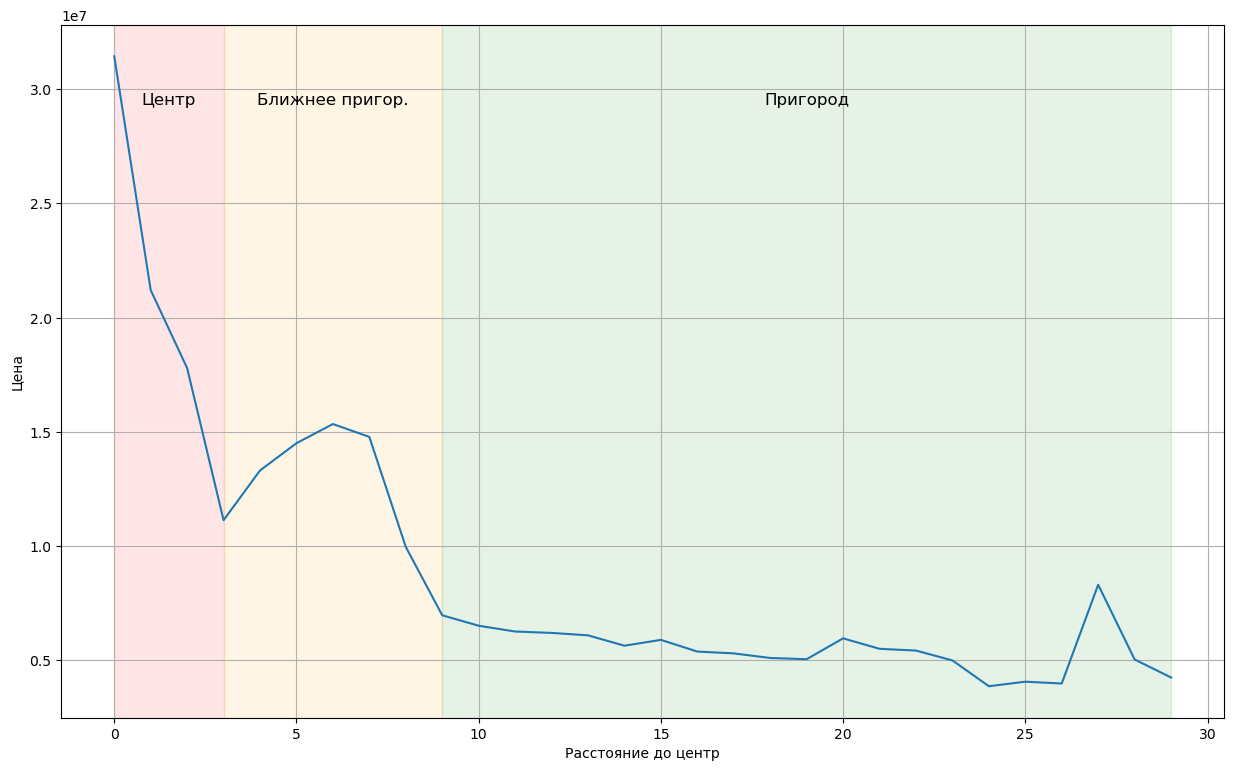

In [76]:
mean_price_spb.plot(grid=True, xlabel='Расстояние до центр', ylabel='Цена', figsize=(15, 9)).axvspan(0, 3, color='red', alpha=0.1)
plt.axvspan(3, 9, color='orange', alpha=0.1)
plt.axvspan(9, mean_price_spb.index.max(), color='green', alpha=0.1)
ylim = plt.ylim()
plt.text(3/2,   ylim[1]*0.9, 'Центр', ha='center', va='center', fontsize=12)
plt.text((3+9)/2, ylim[1]*0.9, 'Ближнее пригор.', ha='center', va='center', fontsize=12)
plt.text((9 + mean_price_spb.index.max())/2,   ylim[1]*0.9, 'Пригород', ha='center', va='center', fontsize=12)

Для более точного определения стоимости недвижимости следует отдельное внимание уделять расстоянию от центра, этажу, общей и жилой площади, это позволит получать наиболее точный прогноз